In [1]:
import blobfile as bf
import numpy as np
import os


In [2]:
def get_guided_arr_dict(path, in_channels):
    # 该函数用于从指定的路径中读取所有的npy文件，并将其转换为字典形式，key为文件名(类别)，value为对应的数组CHW，另外根据in_channels参数获取相应层数的海温
    guided_arr_dict = {}
    for file in bf.listdir(path):
        # file only contains the name of the file, not the full path
        if file.endswith(".npy"):
            with bf.BlobFile(os.path.join(path,file), "rb") as f:
                # array [180, 360, depth_level] HWC and rescale to [-1, 1]
                arr = np.load(f)   
                arr = arr.astype(np.float32)
                # transpose to C*H*W
                arr = np.transpose(arr, (2, 0, 1))
                arr = arr[:in_channels] # ic*H*W
                # save to dict
                guided_arr_dict[str(file)[0:-4]] = arr
    return guided_arr_dict


def split_guided_eval(arr, guided_rate):
    """
    Args:
        arrs: List of arrays (shape [H, W]) or a single array (shape [N, H, W]).
        guided_rate: Fraction of data to keep for guidance (e.g., 0.8 means 80% guided, 20% eval).
    Returns:
        guided_arrs: Arrays with only the guided part (non-guided set to NaN).
        eval_arrs: Arrays with only the eval part (non-eval set to NaN).
    """
    arr = np.asarray(arr)  # Ensure input is a NumPy array

    # Precompute masks for non-NaN positions
    non_nan_mask = ~np.isnan(arr)  # CHW
    num_non_nan = non_nan_mask.sum(axis=(1, 2))  # Number of non-NaN per array

    # Generate random indices for eval (non-guided) positions
    rng = np.random.default_rng()  # Random number generator
    eval_indices = []
    for i in range(len(arr)):
        mask_indices = np.argwhere(non_nan_mask[i])  # HW non-nan indices of i-th array
        n_eval = int(len(mask_indices) * (1 - guided_rate)) # num of eval
        selected = rng.choice(len(mask_indices), size=n_eval, replace=False) # index of mask_indices for eval 
        eval_indices.append(mask_indices[selected]) # CHW 

    # Create eval_mask (1=eval, 0=guided or originally NaN)
    eval_mask = np.zeros_like(arr, dtype=bool)
    for i, idx in enumerate(eval_indices):
        eval_mask[i, idx[:, 0], idx[:, 1]] = True

    # Generate guided_arrs and eval_arrs
    # eval_mask is T, others: nan
    eval_arrs = np.where(~eval_mask, np.nan, arr) 
    # guided_arrs: eval_mask T is nan or nan is nan
    guided_arrs = np.where(eval_mask | ~non_nan_mask, np.nan, arr)  # Keep guided + originally non-NaN
    

    return guided_arrs, eval_arrs  # Remove batch dim if input was single array


In [ ]:
dir_path = '/home/bingxing2/ailab/scxlab0052/data/yysong'

# with bf.BlobFile(dir_path, "rb") as f:
#     arr = np.load(f) 
#     arr0 = np.nan_to_num(arr, nan=0.0)
#     arr0 = np.transpose(arr0, (2, 0, 1))[0]  # 海表数据

arr_dict = get_guided_arr_dict(dir_path,1)
arr = arr_dict['2024-01']

num_sparse_point = np.sum(~np.isnan(arr))
print(num_sparse_point)  # 6403

arr0 = np.nan_to_num(arr, nan=0.0)
arr1, arr2 = split_guided_eval(arr, 0.8)
arr1 = np.nan_to_num(arr1, nan=0.0)
arr2 = np.nan_to_num(arr2, nan=0.0)

6403


In [ ]:
data_path = "/home/bingxing2/ailab/scxlab0052/yysong/improved-diffusion-main/tmp_data/185001.npy"

with bf.BlobFile(data_path, "rb") as f:
    # array [180, 360, depth_level] HWC and rescale to [-1, 1]
    arr4 = np.load(f)   
    
print(np.sum(~np.isnan(arr4)))  # 海洋：42513
# 陆地：22287

# 0.1：4251
# sparse: 

42513


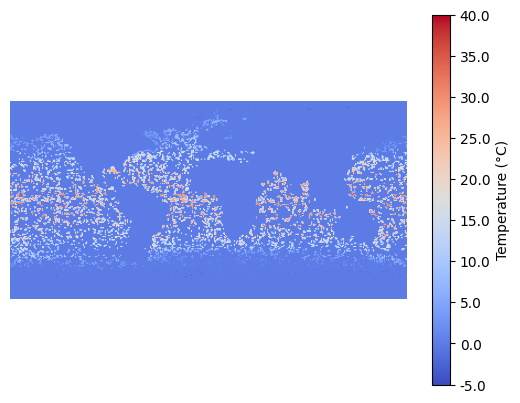

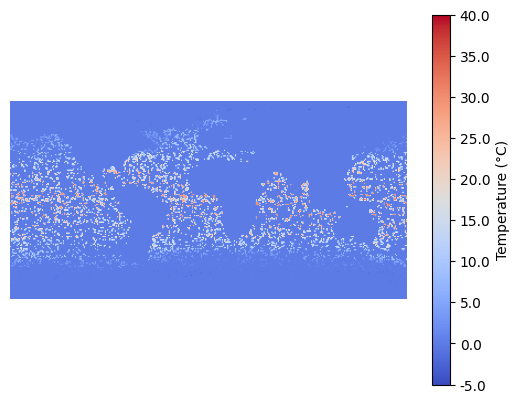

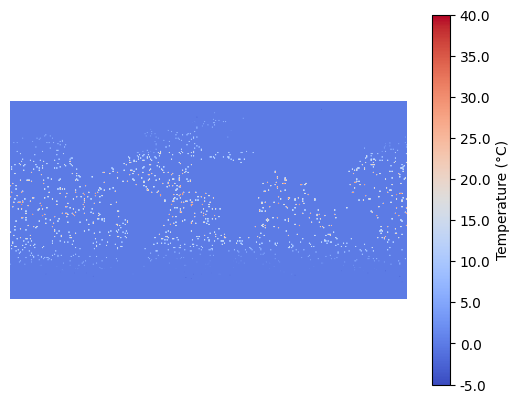

In [10]:
def plt_image(arr):
    import matplotlib.pyplot as plt
    im = plt.imshow(arr.squeeze(), cmap='coolwarm', vmin=-5, vmax=40, origin='lower')  # 使用自定义颜色映射  cmap='RdYlBu'反了  bwr
    # plt.title(f"Sample {i}")
    plt.axis('off')  # 隐藏坐标轴

    # 自定义颜色条的刻度标签
    cbar = plt.colorbar(im, orientation='vertical')  # 添加颜色条
    cbar.set_label('Temperature (°C)')  # 设置颜色条标签
    cbar_ticks = np.linspace(-5, 40, num=10)  # 生成颜色条的刻度
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])  # 在真实值的基础上减去 5
    plt.show()

plt_image(arr0)
plt_image(arr1)
plt_image(arr2)

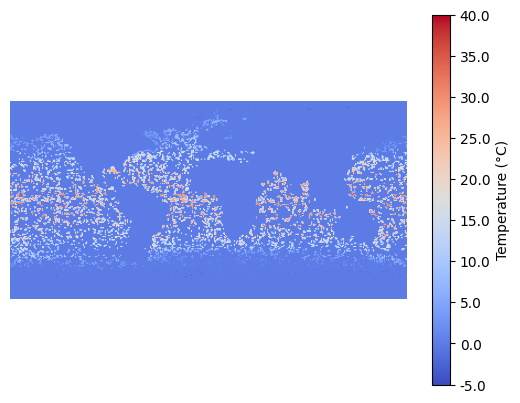

0


In [ ]:
def plt_image(arr):
    import matplotlib.pyplot as plt
    im = plt.imshow(arr.squeeze(), cmap='coolwarm', vmin=-5, vmax=40, origin='lower')  # 使用自定义颜色映射  cmap='RdYlBu'反了  bwr
    # plt.title(f"Sample {i}")
    plt.axis('off')  # 隐藏坐标轴

    # 自定义颜色条的刻度标签
    cbar = plt.colorbar(im, orientation='vertical')  # 添加颜色条
    cbar.set_label('Temperature (°C)')  # 设置颜色条标签
    cbar_ticks = np.linspace(-5, 40, num=10)  # 生成颜色条的刻度
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])  # 在真实值的基础上减去 5
    plt.show()

plt_image(arr0)

In [ ]:
print(arr)  # 原始arr没有的地方是nan

In [2]:
import numpy as np

arr = np.array([[[1,2,3],[1,2,3],[1,2,3]],[[1,2,3],[1,2,3],[1,2,3]]])
# 在增加一个维度，将原有的arr复制3份

arr1 = arr[0]
print(arr1, arr1.shape)
add_dim1 = np.expand_dims(arr1, axis=0)
print(add_dim1, add_dim1.shape)

arr2 = arr[:1]
print(arr2, arr2.shape)

for a in arr:
    print(a.shape)



[[1 2 3]
 [1 2 3]
 [1 2 3]] (3, 3)
[[[1 2 3]
  [1 2 3]
  [1 2 3]]] (1, 3, 3)
[[[1 2 3]
  [1 2 3]
  [1 2 3]]] (1, 3, 3)
(3, 3)
(3, 3)


In [20]:
path = "/home/bingxing2/ailab/scxlab0052/data/yysong/"
guided_arr_dict = {}
import os
for file in bf.listdir(path):
    # file only contains the name of the file, not the full path
    if file.endswith(".npy"):
        with bf.BlobFile(os.path.join(path,file), "rb") as f:
            arr = np.load(f) # 返回结果为 array [180, 360, 38] HWC
            # arr = np.nan_to_num(arr, nan=0.0) # 不能转换，不然无法判断哪里没有值
            arr = 2 * (arr + 5) / 45 - 1   # rescale [-1, 1]
            arr = arr.astype(np.float32)
            arr = np.transpose(arr, (2, 0, 1))[0]  # 海表数据CHW
            print(str(file)[0:-4])
            guided_arr_dict[str(file)[0:-4]] = arr
print(guided_arr_dict.keys())

2024-01
2024-02
dict_keys(['2024-01', '2024-02'])


In [24]:
# # import torch as th

arr = guided_arr_dict['2024-01']

print(type(arr), arr.shape)
# y = th.from_numpy(np.stack([arr]* 3, axis=0)).float()
# print(type(y), y.shape)

<class 'numpy.ndarray'> (180, 360)


In [ ]:
import numpy as np

mask = np.array([[1,0,0,1],[np.nan,1,1,0]])

print(mask)

mask_indices = np.argwhere(mask == 1)

print(mask_indices)

select_indices = np.random.choice(mask_indices.shape[0], 2, replace=False)

print(select_indices)
print(mask[tuple([1,1])])
print(0*np.nan)


[[ 1.  0.  0.  1.]
 [nan  1.  1.  0.]]
[[0 0]
 [0 3]
 [1 1]
 [1 2]]
[3 1]
1.0
nan


In [28]:
a = 0
if a:
    print("a")
else:  
    print("a is nan")

a is nan


In [ ]:
def random(a):
    n = np.random.randint(0, 2)
    return a**n

a = 3
random_list = [random(a) for i in range(10)]

In [5]:
cond_fn = None
flag = cond_fn is None
if flag:
    print("cond_fn is None")  # conf_dn不是空，flag为True
else:   
    print("cond_fn is not None")  # cond_fn是空，flag为False

cond_fn is None
